In [1]:
import os
import ast
import json
from typing import Annotated, TypedDict
from IPython.display import display, Image

from dotenv import load_dotenv
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langchain_openai import ChatOpenAI

In [2]:
from langgraph.graph import START, StateGraph
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition

In [3]:
load_dotenv()
print("STARTED")


LITE_LLM_API_KEY = os.getenv("OPENAI_API_KEY")
LITE_LLM_URL = os.getenv("OPENAI_BASE_URL")
LITE_MODEL = os.getenv("OPENAI_MODEL")


@tool
def calculator(query: str) -> str:
    """A simple calculator tool. Input should be a mathematical expression."""
    return ast.literal_eval(query)

STARTED


In [4]:
search = DuckDuckGoSearchRun()
tools = [calculator, search]
llm = ChatOpenAI(
    model=LITE_MODEL, api_key=LITE_LLM_API_KEY, base_url=LITE_LLM_URL
).bind_tools(tools)

In [5]:
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [6]:
def model_node(state: State) -> State:
    print(f"Model node: {state['messages']}")
    res = llm.invoke(state["messages"])
    return {"messages": [res]}


builder = StateGraph(State)
builder.add_node("model", model_node)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "model")
builder.add_conditional_edges("model", tools_condition)
builder.add_edge("tools", "model")
graph = builder.compile()

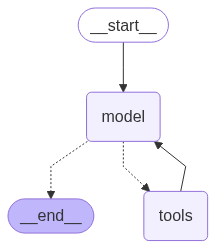

In [7]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [9]:
msg = {
    "messages": [
        HumanMessage(
            """How old was the 30th president of the United States when he died?"""
        )
    ]
}
for c in graph.stream(msg):
    print(c)

Model node: [HumanMessage(content='How old was the 30th president of the United States when he died?', additional_kwargs={}, response_metadata={}, id='f5f55a44-b671-45be-90e3-c788daa0cabc')]
{'model': {'messages': [AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_gJONwLFfo8KOklPJaJITqtGj', 'function': {'arguments': '{"query":"30th president of the United States age at death"}', 'name': 'duckduckgo_search'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 27, 'prompt_tokens': 114, 'total_tokens': 141, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_57db37749c', 'id': 'chatcmpl-BiKriEXZWy9Zn3KDpSIuImnkmvYIk', 'service_tier': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run--5173f2ac-5f0